In [37]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
from scipy.constants import N_A
from scipy import linalg
import math, cmath
from sympy import *


In [38]:
Target_cell_number = 2e5
well_size = 150e-6
t_end = 60*60*10*10
t = np.geomspace(1e-10, t_end, 150)
tspan = [1e-10, t_end]
z0 = [0, 0]
tumour_cell_radius = 8e-6
tumour_cell_surface_area = 4*math.pi*((tumour_cell_radius)**2)



In [39]:
def model_S_monospecific(t, z, Ainit, rtot, kon, k2, koff):
     k = Ainit*kon
     Atot = well_size*N_A*Ainit/Target_cell_number
     A0 = Atot - z[0] - z[1] 
     Ag = rtot - z[0] - 2*z[1]

     dA10 = 2*(k*Ag*A0/Atot) - koff*z[0] - (k2*Ag*z[0]) + 2*koff*z[1]
     dA11 = (k2*Ag*z[0]) - 2*koff*z[1]

     return [dA10, dA11]

def model_S_dimensionless(t, z, alpha1, alpha2, beta):

     A0 = beta - z[0] - z[1] 
     Ag = 1 - z[0] - 2*z[1]

     dA10 = 2*(alpha1*Ag*A0) - z[0] - (alpha2*Ag*z[0]) + 2*z[1]
     dA11 = (alpha2*Ag*z[0]) - 2*z[1]

     return [dA10, dA11]

def model_S_dimensionless(t, z, alpha1, alpha2, beta):

     A0 = beta - z[0] - z[1] 
     Ag = 1 - z[0] - 2*z[1]

     dA10 = 2*(alpha1*Ag*A0) - z[0] - (alpha2*Ag*z[0]) + 2*z[1]
     dA11 = (alpha2*Ag*z[0]) - 2*z[1]

     return [dA10, dA11]

def dxdt(x, y, alpha1, alpha2, beta):
     return 2*alpha1*(1-x-2*y)*(beta-x-y) -x - alpha2*x*(1-x-2*y) + 2*y

def dydt(x, y, alpha2):
     return  alpha2*x*(1-x-2*y) - 2*y

In [191]:
sigma = well_size*N_A/Target_cell_number

def A1_steady_state(x, Ainit, k1, koff, k2, rtot):
    k1 = k1/sigma
    Atot = well_size*N_A*Ainit/Target_cell_number
    express = 2*k1*(rtot - x - 2*(k2*x*(rtot-x)/(2*(koff + k2*x))))*(Atot - x - (k2*x*(rtot-x)/(2*(koff + k2*x)))) -koff*x - k2*x*(rtot - x - 2*(k2*x*(rtot-x)/(2*(koff + k2*x)))) +2*koff*(k2*x*(rtot-x)/(2*(koff + k2*x)))

    return express

def A2_steady_state(x, k2, koff, rtot):
    express = k2*x*(rtot-x)/(2*(koff + k2*x))

    return express

"""
def A1_steady_state(x, Ainit, k1, koff, k2, rtot):
    k1 = k1/sigma
    Atot = well_size*N_A*Ainit/Target_cell_number
    express = 2*k1*((rtot*Atot -rtot*x - Atot*x + (x**2))*((2*(koff + k2*x))**2) + 6*x*(k2*x*(rtot-x)*(koff + k2*x)) - 
                    4*Atot*k2*x*(rtot-x)*(koff +k2*x) + 2*((k2*x*(rtot-x))**2)) -koff*x* ((2*(koff + k2*x))**2) -k2*x*((rtot-x)*((2*(koff + k2*x))**2) 
                    - 4*k2*x*(rtot-x)*(koff + k2*x)) + 4*koff*k2*x*(rtot-x)*(koff + k2*x)
    
    return express
"""


'\ndef A1_steady_state(x, Ainit, k1, koff, k2, rtot):\n    k1 = k1/sigma\n    Atot = well_size*N_A*Ainit/Target_cell_number\n    express = 2*k1*((rtot*Atot -rtot*x - Atot*x + (x**2))*((2*(koff + k2*x))**2) + 6*x*(k2*x*(rtot-x)*(koff + k2*x)) - \n                    4*Atot*k2*x*(rtot-x)*(koff +k2*x) + 2*((k2*x*(rtot-x))**2)) -koff*x* ((2*(koff + k2*x))**2) -k2*x*((rtot-x)*((2*(koff + k2*x))**2) \n                    - 4*k2*x*(rtot-x)*(koff + k2*x)) + 4*koff*k2*x*(rtot-x)*(koff + k2*x)\n    \n    return express\n'

In [194]:
A0s = np.geomspace(1e-12, 1e-5, 1000)

A1_st_sim = np.zeros_like(A0s)
A1_st_root = np.zeros_like(A0s)
A2_st_sim = np.zeros_like(A0s)
A2_st_root = np.zeros_like(A0s)

D = 1e-14
k2 = 4*D/tumour_cell_surface_area

for i, Ainit in enumerate(A0s):

    A1_st_root[i] = fsolve(A1_steady_state, [0], args=(Ainit, 1e5, 1e-2, k2, 1e7))
    A2_st_root[i] = A2_steady_state(A1_st_root[i], k2, 1e-2, 1e7)
    z = solve_ivp(model_S_monospecific, tspan, z0, method='Radau', t_eval=t, args=(Ainit, 1e7, 1e5, k2, 1e-2))
    A1 = z.y[0]
    A2 = z.y[1]
    A1_st_sim[i] = A1[-1]
    A2_st_sim[i] = A2[-1]

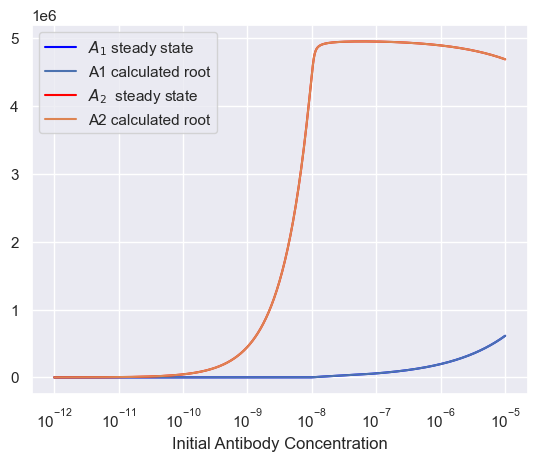

In [195]:
sns.set_theme()
plt.plot(A0s, A1_st_sim, label = r'$A_1$' + ' steady state', color='blue')
plt.plot(A0s, A1_st_root, label = 'A1 calculated root')
plt.plot(A0s, A2_st_sim, label = r'$A_2$ ' + ' steady state', color='red')
plt.plot(A0s, A2_st_root, label = 'A2 calculated root')

plt.xscale('log')
plt.legend(loc='best')
plt.xlabel('Initial Antibody Concentration')
plt.show()

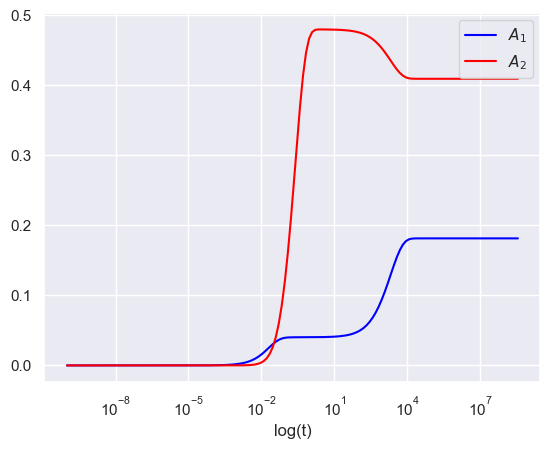

In [63]:
sns.set_theme()
z = solve_ivp(model_S_monospecific, tspan, z0, method='Radau', t_eval=t, args=(1e-5, 1e6, 1e5, k2, 1e-4))
plt.plot(t, z.y[0]/1e6, label=r'$A_1$', c='blue')
plt.plot(t, z.y[1]/1e6, label = r'$A_2$', c='red')
plt.legend(loc='best')
plt.xlabel('log(t)')
plt.xscale('log')
plt.show()

In [81]:
def A2_nullcline1(A2, alpha2):
    a = 1
    b = 2*A2 -1 
    c = (2/alpha2)
    express = (-b + np.sqrt((b)**2 - 4*a*c))/(2*a)

    return express

def A2_nullcline2(A2, alpha2):
    a = 1
    b = 2*A2 -1 
    c = (2/alpha2)
    express = (-b - np.sqrt((b)**2 - 4*a*c))/(2*a)

    return express

def A1_nullcline1(A2, alpha1, alpha2, beta):
    a = (2*alpha1 + alpha2)
    b = (2*alpha1)*(3*A2 - beta - 1)  -1 -alpha2*(1+2*A2)
    c = 2*alpha1*(beta*(1- 2*A2) - A2 + 2*((A2)**2)) + 2*A2
    express = (-b - np.sqrt((b)**2 - 4*a*c))/(2*a)

    return express

def A1_nullcline2(A2, alpha1, alpha2, beta):
    a = (2*alpha1 + alpha2)
    b = (2*alpha1)*(3*A2 - beta - 1)  -1 -alpha2*(1+2*A2)
    c = 2*alpha1*(beta*(1- 2*A2) - A2 + 2*((A2)**2)) + 2*A2
    express = (-b + np.sqrt((b)**2 - 4*a*c))/(2*a)

    return express



In [95]:
def A2_nullcline(x, alpha2):

    return (alpha2*x*(1-x))/(2*(1+ x*alpha2))

def A1_nullcline1(A1, alpha1, alpha2, beta):
    a = (4*alpha1)
    b = (2*alpha1)*(3*A1 - 2*beta - 1)  + 2 + 2*alpha2*A1
    c = 2*alpha1*(beta - A1 - A1*beta + ((A1)**2)) - A1 -alpha2*A1*(1-A1)
    express = (-b - np.sqrt((b)**2 - 4*a*c))/(2*a)

    return express

def A1_nullcline2(A1, alpha1, alpha2, beta):
    a = (4*alpha1)
    b = (2*alpha1)*(3*A1 - 2*beta - 1)  + 2 + 2*alpha2*A1
    c = 2*alpha1*(beta - A1 - A1*beta + ((A1)**2)) - A1 -alpha2*A1*(1-A1)
    express = (-b + np.sqrt((b)**2 - 4*a*c))/(2*a)

    return express

0.2214052089565129
4973.5919716217295
451.66055700000004


/var/folders/qf/lh9kspxj3zx7v12f8f3xdfbw0000gn/T/ipykernel_7244/4036392180.py:9: RuntimeWarning: invalid value encountered in sqrt
  express = (-b - np.sqrt((b)**2 - 4*a*c))/(2*a)
/var/folders/qf/lh9kspxj3zx7v12f8f3xdfbw0000gn/T/ipykernel_7244/4036392180.py:17: RuntimeWarning: invalid value encountered in sqrt
  express = (-b + np.sqrt((b)**2 - 4*a*c))/(2*a)


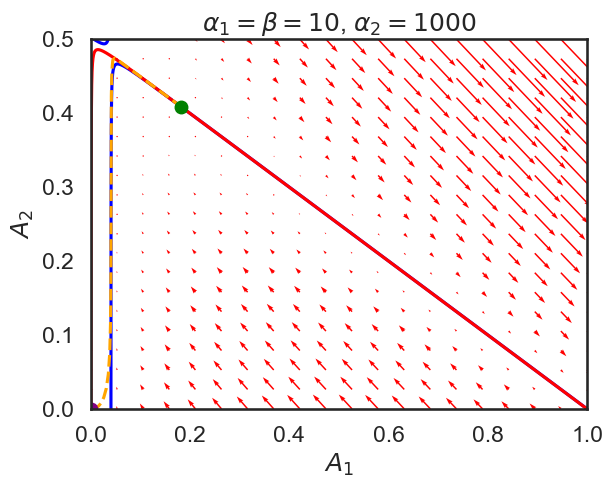

In [117]:
sns.set_theme(style = "white")
sns.set_context("talk")

kon = 1e5
rtot = 1e5
x1 = np.linspace(0, 1, 50000)
x2 = np.linspace(0, 1/2, 500)
D = 1e-15
k2 = 4*D/tumour_cell_surface_area
koff = 1e-4
Ainit = 1e-7
Atot = well_size*N_A*Ainit/Target_cell_number
t_end = 60*60*10*1000000000
t = np.geomspace(1e-10, t_end, 150)
tspan = [1e-10, t_end]

sigma = well_size*N_A/Target_cell_number
alpha1 = kon*rtot/(sigma*koff)
print(alpha1)
alpha2 = k2*rtot/koff
print(alpha2)
beta = Atot/rtot
print(beta)
#alpha1 = 100
#alpha2 = 10
#beta = 100

t1 = 0

z = solve_ivp(model_S_dimensionless, tspan, z0, method='Radau', t_eval=t, args=(alpha1, alpha2, beta))
y1 = np.linspace(0, 1, 20)
y2 = np.linspace(0, 0.5, 20)

Y1, Y2 = np.meshgrid(y1, y2)

A1, A2 = np.zeros(Y1.shape), np.zeros(Y2.shape)

Ni, Nj = Y1.shape

for i in range(Ni):
    for j in range(Nj):
        x = Y1[i, j]
        y = Y2[i, j]
        yprime = model_S_dimensionless(t1, [x, y], alpha1, alpha2, beta)
        A1[i, j] = yprime[0]
        A2[i, j] = yprime[1]

plt.plot(x1, A1_nullcline1(x1, alpha1, alpha2, beta),  c='blue', label='A1 nullcline')
plt.plot(x1, A1_nullcline2(x1, alpha1, alpha2, beta), c= 'blue')#, label='null 3')
plt.plot(x1, A2_nullcline(x1, alpha2),  c='red', label='A1 nullcline')
Q = plt.quiver(Y1, Y2, A1, A2, color='red')
z1 = z.y[0]
z2 = z.y[1]
plt.plot(z1, z2, '--', label='trajectory', c='orange')
plt.plot([z1[0]], [z2[0]], 'o', c = 'purple',label='initial condition')
plt.plot([z1[-1]], [z2[-1]], 'o', c='green', label='equilibrium')

#f = A2_steady_state(x1, alpha2)
#g = A2_alternative_null_minus(x2, alpha1, alpha2, beta)



#plt.legend(loc='best')


plt.xlim(0, 1)
plt.ylim(0, 0.5)
plt.xlabel(r'$A_1$')
plt.title(r'$\alpha_1 = \beta = 10$' + r', $\alpha_2=1000$')
plt.ylabel(r'$A_2$')
#sns.despine()
plt.show()


In [163]:
A0s = np.geomspace(1e-12, 1e-5, 50)
alpha1s = np.geomspace(1e-3, 20, 50)
alpha2s = np.geomspace(1e1, 1e5, 50)
k1s = np.geomspace(1e4, 1e6, 50)
r_abs = np.linspace(1e-8, 5e-8, 50)
rtot = 1e5
kon = 1e5
koff = 1e-4
sigma = well_size*N_A/Target_cell_number

r_ab = 1.25e-8
r_cell = 8e-6
Target_cell_number = 2e5
reaction_volume = (2*math.pi/3)*(r_ab**3)
Ageff = (1/reaction_volume)*(rtot/N_A)*((4*math.pi*r_cell)**2)
assay_volume = 150e-6
D = 1e-14
#k2 = 4*D/tumour_cell_surface_area
alpha1 = kon*rtot/(sigma*koff)
#alpha2 = k2*rtot/koff
k1 = 1e5

Y = np.zeros((len(alpha1s), len(alpha2s)))
Y1 = np.zeros((len(alpha1s), len(alpha2s)))

for i, r_ab in enumerate(r_abs):
    for j, Ainit in enumerate(A0s):
        alpha1 = k1*rtot/(sigma*koff)
        reaction_volume = (2*math.pi/3)*(r_ab**3)
        Ageff = (1/reaction_volume)*(rtot/N_A)*((4*math.pi*r_cell)**2)
        k2 = k1*Ageff/rtot
        alpha2 = k2*rtot/koff
        Atot = well_size*N_A*Ainit/Target_cell_number
        beta = Atot/rtot
        z = solve_ivp(model_S_dimensionless, t_span=tspan, y0=[0,0], method='Radau', t_eval=t, args=(alpha1, alpha2, beta))
        A1 = z.y[0]
        A2 = z.y[1]
        Y[i, j,] = A1[-1]
        Y1[i, j] = A2[-1]


<AxesSubplot:>

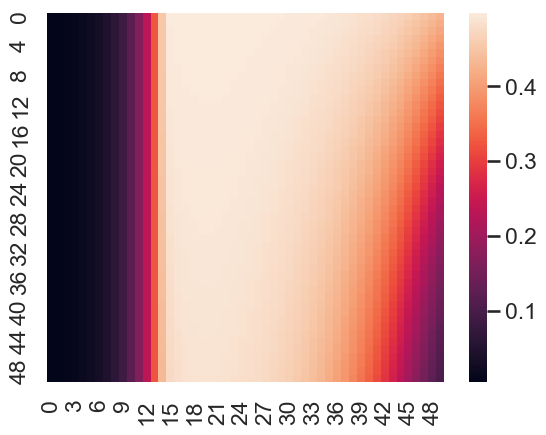

In [165]:
sns.heatmap(Y1)

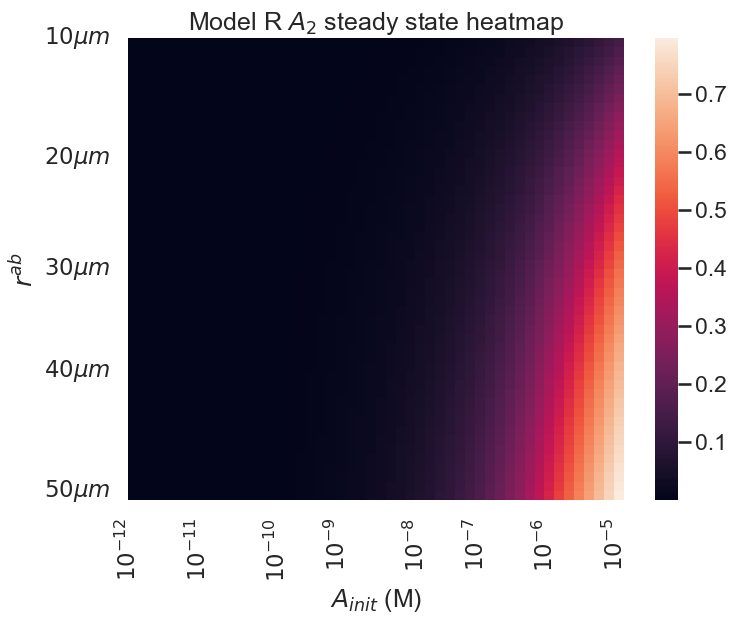

In [168]:


fig, ax = plt.subplots(figsize=(8, 6))
line = sns.heatmap(Y, xticklabels=True, yticklabels=True, ax=ax) 
#ax = sns.heatmap(Y[0,:,:], xticklabels=True, yticklabels=True, ax=ax)
ax.set_xticks([0, 7, 15, 21, 29, 35, 42, 49])
ax.set_yticks([0, 13, 25, 36, 49])
#ax.set_yticklabels([10, r'$10^2$', r'$10^3$', r'$10^4$', r'$10^5$'])
ax.set_yticklabels([r'$10 \mu m$',r'$20 \mu m$', r'$30 \mu m$', r'$40 \mu m$', r'$50 \mu m$'])
ax.set_xticklabels([r'$10^{-12}$', r'$10^{-11}$', r'$10^{-10}$', r'$10^{-9}$', r'$10^{-8}$', r'$10^{-7}$', r'$10^{-6}$', r'$10^{-5}$'])
ax.set_xlabel(r'$A_{init}$' + ' (M)')
ax.set_ylabel(r'$r^{ab}$')
ax.set_title('Model R ' + r'$A_2$' + ' steady state heatmap')



plt.show()

In [ ]:
#from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.gca(projection='3d')

x = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, x)
Z = np.sin(X)*np.sin(Y)

levels = np.linspace(-1, 1, 40)

ax.contourf(alpha1s, A0s, .1*np.sin(3*X)*np.sin(5*Y), zdir='z', levels=.1*levels)
ax.contourf(alpha1s, A0s, 3+.1*np.sin(5*X)*np.sin(8*Y), zdir='z', levels=3+.1*levels)
ax.contourf(alpha1s, A0s, 7+.1*np.sin(7*X)*np.sin(3*Y), zdir='z', levels=7+.1*levels)

ax.legend()
ax.set_xlim3d(0, 1)
ax.set_ylim3d(0, 1)
ax.set_zlim3d(0, 10)

plt.show()

/var/folders/qf/lh9kspxj3zx7v12f8f3xdfbw0000gn/T/ipykernel_8647/3569488006.py:6: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


TypeError: Length of x (50) must match number of columns in z (100)

Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.10/site-packages/matplotlib/cbook/__init__.py", line 287, in process
    func(*args, **kwargs)
  File "/opt/homebrew/lib/python3.10/site-packages/matplotlib/widgets.py", line 585, in <lambda>
    return self._observers.connect('changed', lambda val: func(val))
  File "/var/folders/qf/lh9kspxj3zx7v12f8f3xdfbw0000gn/T/ipykernel_8647/943306124.py", line 37, in update
    line.set_data(f(a1_slider.val))
AttributeError: 'AxesSubplot' object has no attribute 'set_data'
Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.10/site-packages/matplotlib/cbook/__init__.py", line 287, in process
    func(*args, **kwargs)
  File "/opt/homebrew/lib/python3.10/site-packages/matplotlib/widgets.py", line 585, in <lambda>
    return self._observers.connect('changed', lambda val: func(val))
  File "/var/folders/qf/lh9kspxj3zx7v12f8f3xdfbw0000gn/T/ipykernel_8647/943306124.py", line 37, in update
    line.set_data(f(a1_slid

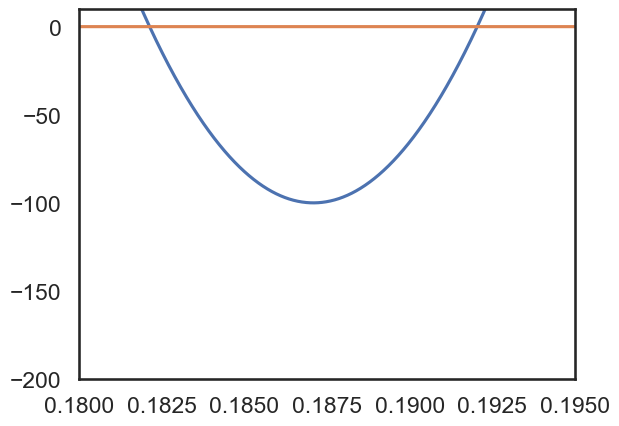

In [ ]:
def nullcline_polly(A1, A2, alpha1, alpha2, beta):
    a = (4*alpha1)
    b = (2*alpha1)*(3*A1 - 2*beta - 1)  + (2*alpha2)*A1 + 2
    c = (2*alpha1)*(beta - A1 -A1*beta +(A1**2)) - A1 - (alpha2)*(A1 - A1**2)
    f1 = 4*alpha1
    f2 = 2*alpha1*(3*A1 - 2*beta - 1) + 2*alpha2*A1 + 2
    f3 = 2*alpha1*(beta - A1*(1 + beta - A1)) - A1 - alpha2*A1*(1-A1)

    return a*(A2**2) + b*A2 + c

def discriminant(A1, alpha1, alpha2, beta):
    a = (4*alpha1)
    b = (2*alpha1)*(3*A1 - 2*beta - 1)  + (2*alpha2)*A1 + 2
    c = (2*alpha1)*(beta - A1 -A1*beta +(A1**2)) - A1 - (alpha2)*(A1 - A1**2)

    return b**2 -4 *a*c

A2s = np.linspace(0, 1, 100000)
plt.xlim(0.18, 0.195)
plt.ylim(-200, 10)
#plt.plot(A2s, nullcline_polly(0.185, A2s, 10, 1000, 10))
plt.plot(A2s, discriminant(A2s, 10, 1000, 10))
plt.plot(A2s, np.zeros_like(A2s))

In [ ]:
rtots = np.linspace(1e2, 1e7, 105)
A0s1 = [1e-12, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
A0s = []
vals = np.linspace(1, 9, 15)

for x in A0s1:
    for val in vals:
        A0s.append(x*val)
A0s = np.asarray(A0s)
print(len(A0s))

Y = np.zeros((105, 105))

k1 = 1e5
x = Symbol('x')
for i in range(len(rtots)):
    print(i)
    rtot = rtots[i]
    for j in range(len(A0s)):
        Ainit = A0s[j]
        Atot = well_size*N_A*Ainit/Target_cell_number
        express = (-2*Atot*k1*Ainit*(rtot - x)*(koff*rtot + k2*x) + x*(((koff*rtot + k2*x)**2) +k1*Ainit*(rtot - x)*(2*koff*rtot + k2*(rtot+x))))/((koff*rtot + k2*x)**2)
        vals = solveset(express, x)
        counter = 0
        for val in vals:
            if np.iscomplex(val) == False:
                if (val >=0) and (val <= rtot):
                    counter +=1
        Y[i][j] = counter

105
0
1


TypeError: Invalid comparison of non-real -9.66667398686631 - 30.310945273494*I